Dimensionality Reduction Comparison
---
#### Method Testing
##### May 2019


Using discrete (`inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz`, Mocosko, _et al_ 2015) and continuous (`inputs/qi_s1_edited_all.csv.gz`) datasets, downsample and feature select, then perform various DR techniques and compare the following:
* __Euclidean cell-cell distance__ correlations before and after transformation/reduction
* __Kullback-Leibler Divergence (KLD)__ explaining the Shannon entropy of the difference between the cumulative probability distributions of unique, normalized cell-cell distances.
* __K-nearest neighbor (Knn)__ preservation

In [24]:
import sys
sys.path.append('../')
from fcc_DRs import *
%matplotlib inline

---
#### 0. read in discrete dataset and preprocess
* cell normalization and _arcsinh-transformation_
* 100-component _PCA_
* _t-SNE_ with perplexity 30
* _cluster_ and _downsample proportionally_ for future processing

In [2]:
P14Retina = RNA_counts.from_file('../inputs/GSM1626793_P14Retina_1.digital_expression.csv.gz', cells_axis=1, labels=[0,0])

In [3]:
P14Retina.data.shape

(6600, 20478)

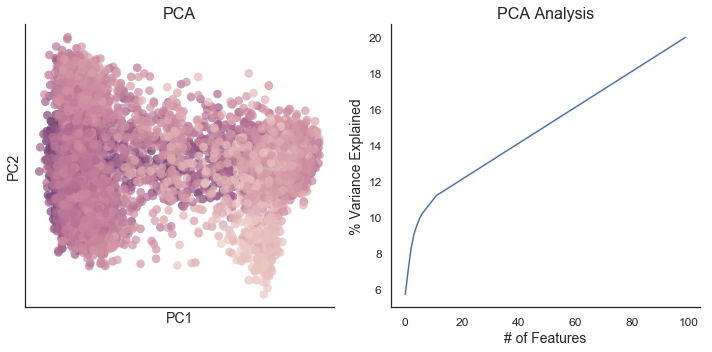

In [4]:
P14Retina_PCA100 = fcc_PCA(P14Retina.arcsinh_norm(norm='l1'), n_components=100)
P14Retina_PCA100.plot_PCA()

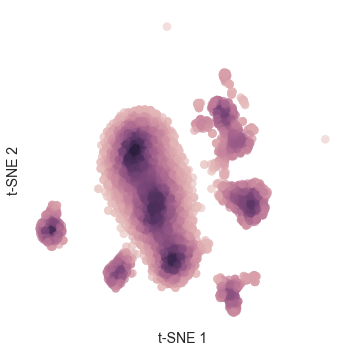

CPU times: user 1min 6s, sys: 2.75 s, total: 1min 9s
Wall time: 1min 9s


In [5]:
%%time 
P14Retina_tSNE = fcc_tSNE(P14Retina_PCA100.results, perplexity=30, seed=18) # use standard perplexity of 30 here
P14Retina_tSNE.plot()

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1318195c0>)

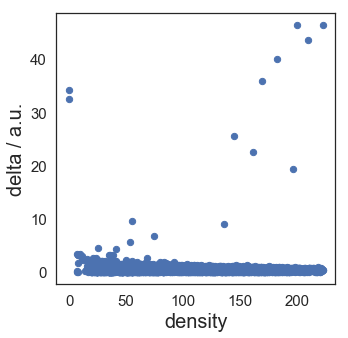

In [6]:
P14Retina_tSNE.clu.draw_decision_graph() # get potential density-peak cluster centers

(<Figure size 360x360 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1313295f8>)

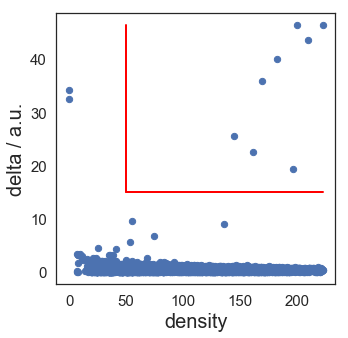

In [7]:
P14Retina_tSNE.clu.assign(50,15) # assign cluster center cutoffs
P14Retina_tSNE.clu.draw_decision_graph(min_delta=P14Retina_tSNE.clu.min_delta, min_density=P14Retina_tSNE.clu.min_density) # plot chosen density-peak cluster centers

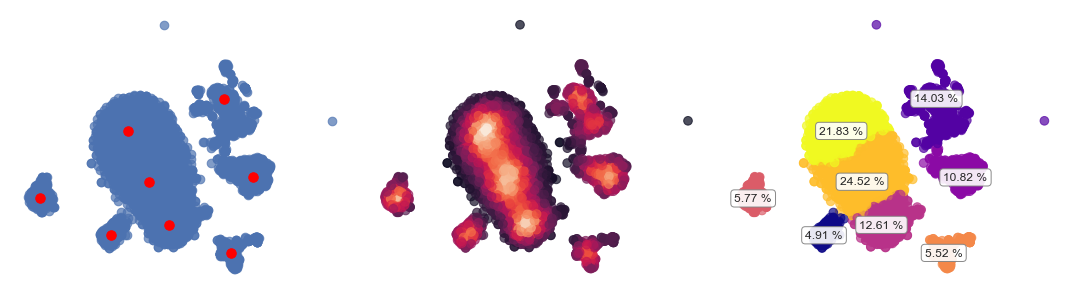

In [8]:
P14Retina_tSNE.plot_clusters() # visualize clustering

In [9]:
print('Silhouette Score: {}\n'.format(P14Retina_tSNE.silhouette_score()))

Silhouette Score: 0.5307749509811401



---
#### 1. subsample discrete dataset and perform DRs
* select _500 most variable genes_
* downsample to _1000 cells_ with _proportional representation from prior clustering_
* _500-component PCA_ as control comparison to _feature-selected counts data_
* _2-component_ PCA
* _t-SNE_ with perplexity 30
* _UMAP_ with perplexity 30
* _DCA_

In [10]:
# select 500 most variable genes
P14Retina_varselect = RNA_counts.var_select(P14Retina, n_features=500) 

In [11]:
# choose 1000 cells with proportional representation from clusters above
P14Retina_0 = RNA_counts.downsample_proportional(P14Retina_varselect, P14Retina_tSNE.clu.membership, n_cells=1000, seed=10)

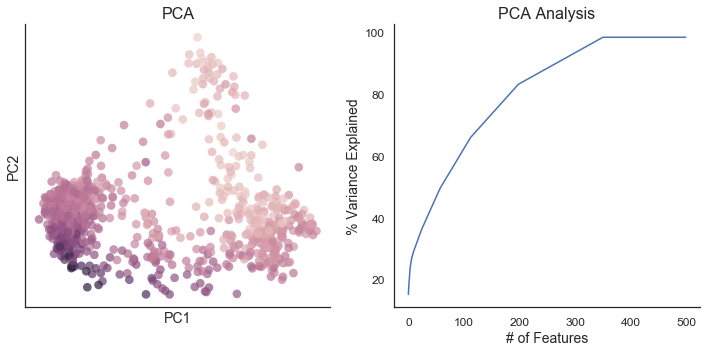

In [13]:
P14Retina_0_PCA500 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=500) # 500 component PCA as control
P14Retina_0_PCA500.plot_PCA()

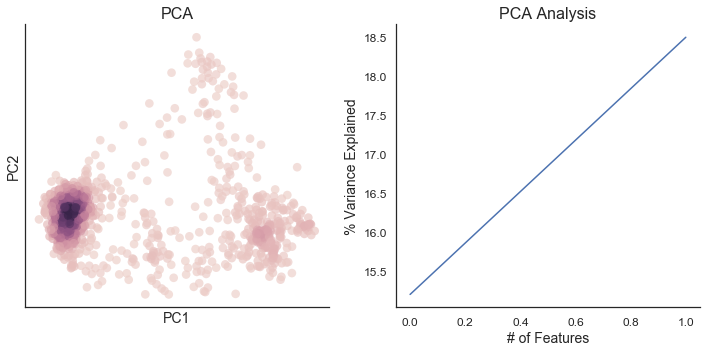

In [15]:
P14Retina_0_PCA2 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=2) # 2 component PCA
P14Retina_0_PCA2.plot_PCA()

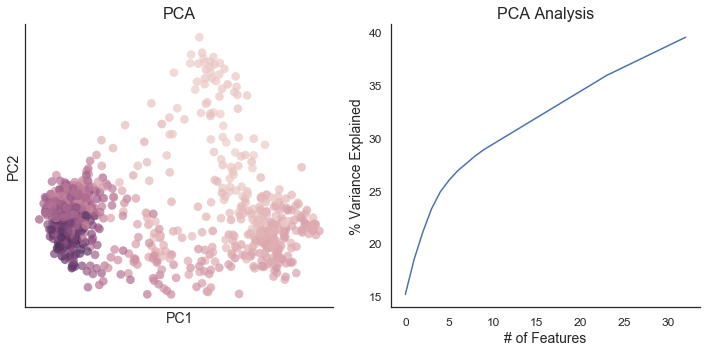

In [16]:
P14Retina_0_PCA33 = fcc_PCA(P14Retina_0.arcsinh_norm(norm='l1'), n_components=33) # 33 component PCA
P14Retina_0_PCA33.plot_PCA()

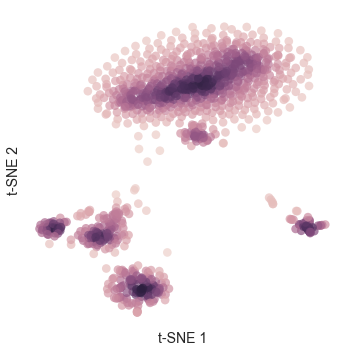

In [17]:
P14Retina_0_tSNE = fcc_tSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30
P14Retina_0_tSNE.plot()

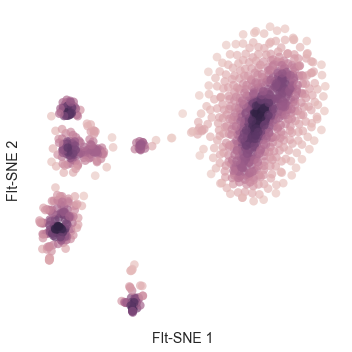

In [18]:
P14Retina_0_FItSNE = fcc_FItSNE(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30
P14Retina_0_FItSNE.plot()

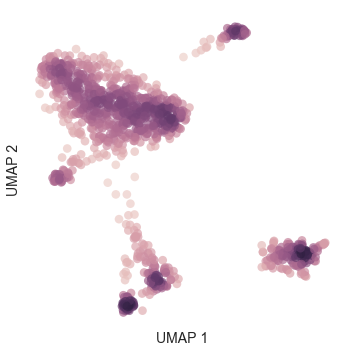

In [19]:
P14Retina_0_UMAP = fcc_UMAP(P14Retina_0.arcsinh_norm(norm='l1'), perplexity=30) # UMAP with perplexity 30
P14Retina_0_UMAP.plot()

In [21]:
%time P14Retina_0_DCA = fcc_DCA(P14Retina_0.counts, norm=False) # DCA on raw counts of 500 selected features

DCA: Successfully preprocessed 500 genes and 1006 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 19.8 s, sys: 791 ms, total: 20.6 s
Wall time: 13.2 s


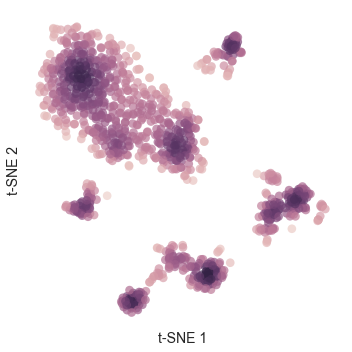

In [22]:
dca = RNA_counts(data=P14Retina_0_DCA.results)
P14Retina_0_DCAtSNE = fcc_tSNE(dca.arcsinh_norm(norm='l1'), perplexity=30, seed=18) # t-SNE with perplexity 30
P14Retina_0_DCAtSNE.plot()

In [29]:
%%time
P14Retina_0_ZIFA = fcc_ZIFA(P14Retina_0.arcsinh_norm(norm='l1'), K=2)

Filtering out all genes which are zero in more than 95.0% of samples. To change this, change p0_thresh.
Number of blocks has been set to 1
Running block zero-inflated factor analysis with N = 1006, D = 477, K = 2, n_blocks = 1
Block sizes [477]
Param change below threshold 1.000e-02 after 13 iterations
CPU times: user 2min 55s, sys: 28.1 s, total: 3min 23s
Wall time: 1min 47s


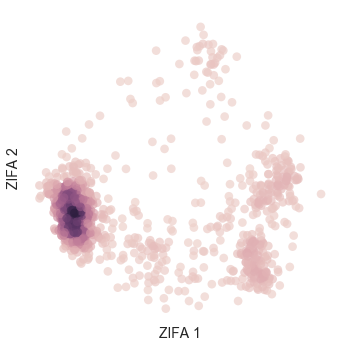

In [30]:
P14Retina_0_ZIFA.plot()

---
#### 2. compare Euclidean distances and Knn preservation before and after DR transformations
* _arcsinh-transform counts_ before calculating distance matrices for fair comparison to DR outputs
* for DCA, _do not arcsinh-transform_ because raw counts are input

In [60]:
# reload functions when editing file
del sys.modules['fcc_DRs']
from fcc_DRs import *

In [31]:
k = 30 # choose value for K-nearest neighbor calculations

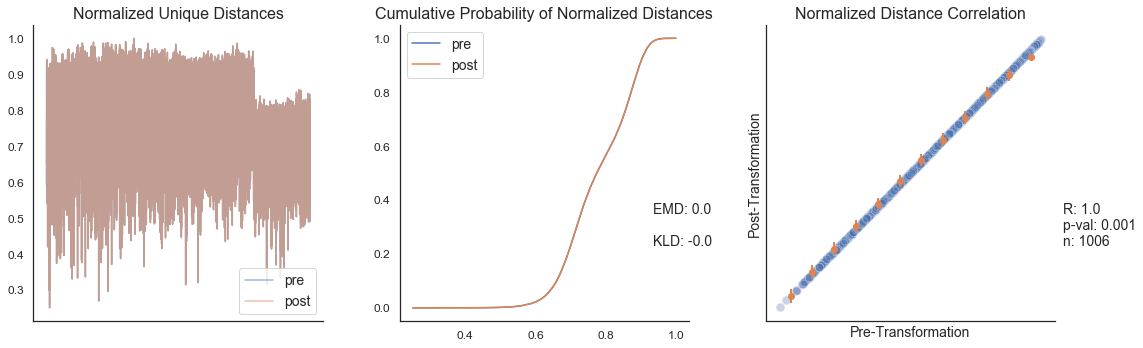

Knn Preservation: 100.0

CPU times: user 34.5 s, sys: 5.39 s, total: 39.9 s
Wall time: 41 s


In [32]:
%%time
# look at 500-component PCA vs 500-feature dataset as control. should have perfect correlation and EMD/KLD.
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA500.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA500.knn_graph(k))))

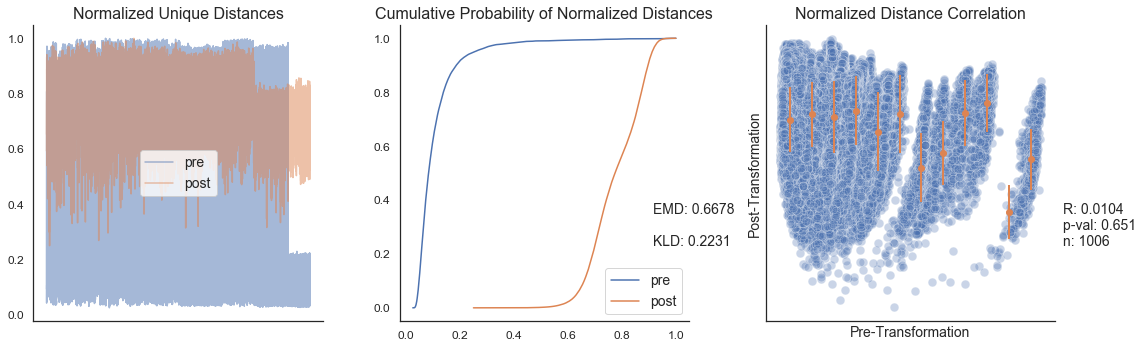

Knn Preservation: 95.5114

CPU times: user 34.4 s, sys: 4.82 s, total: 39.2 s
Wall time: 40.4 s


In [33]:
%%time
# look at arcsinh-transformed vs raw dataset to see how correlation is affected.
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000))
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000))))

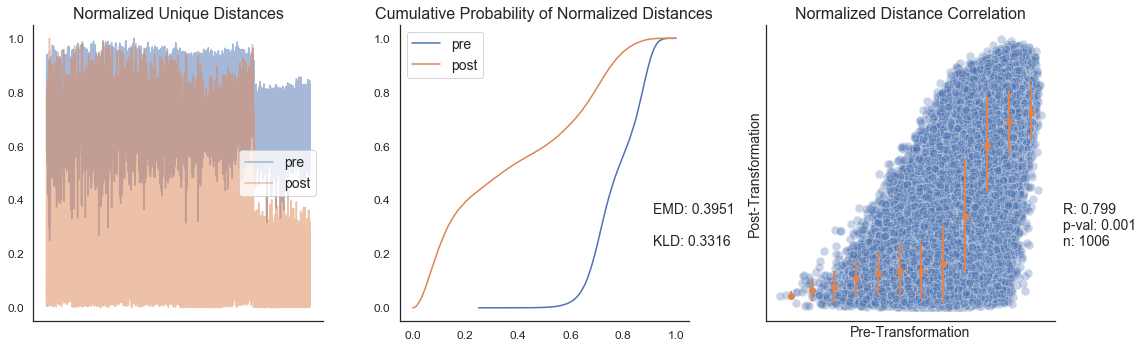

Knn Preservation: 95.9158

CPU times: user 31.3 s, sys: 4.42 s, total: 35.7 s
Wall time: 37.3 s


In [34]:
%%time
# look at 2-component PCA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA2.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA2.knn_graph(k))))

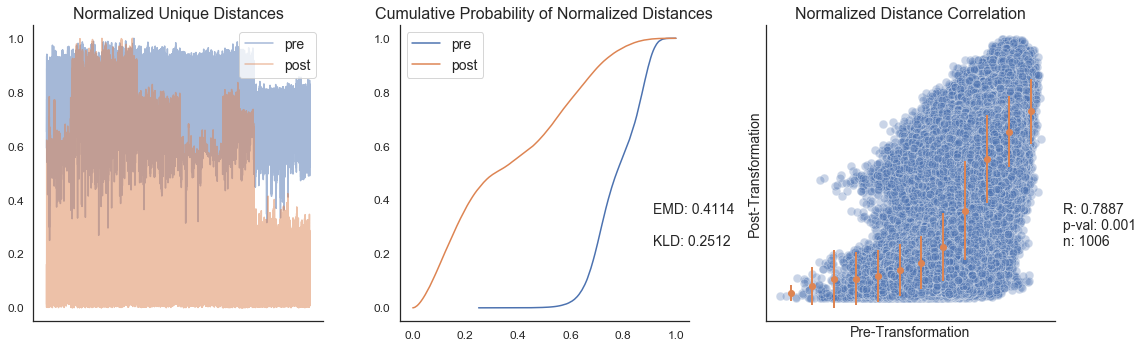

Knn Preservation: 95.6731

CPU times: user 29.8 s, sys: 3.86 s, total: 33.7 s
Wall time: 34.6 s


In [35]:
%%time
# look at t-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_tSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_tSNE.knn_graph(k))))

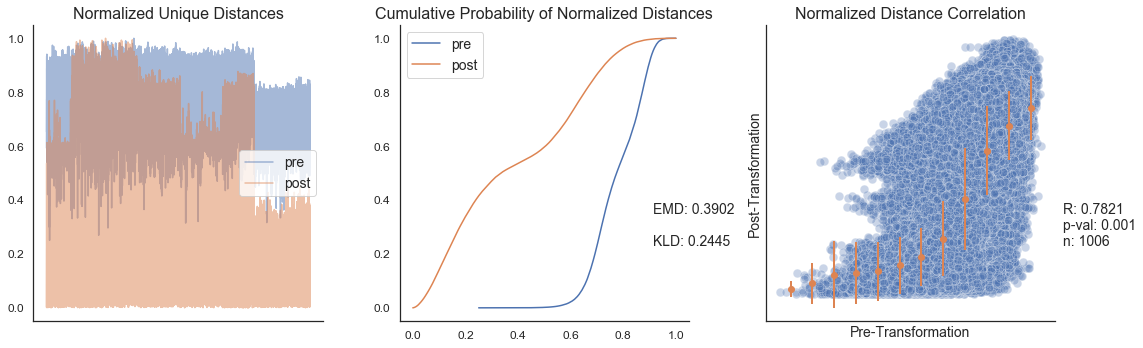

Knn Preservation: 95.6836

CPU times: user 30.5 s, sys: 3.91 s, total: 34.4 s
Wall time: 35.4 s


In [36]:
%%time
# look at FIt-SNE vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_FItSNE.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_FItSNE.knn_graph(k))))

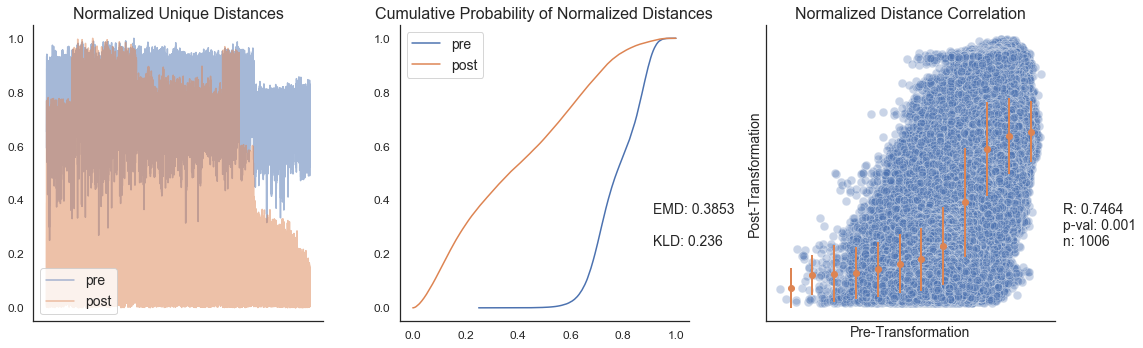

Knn Preservation: 95.3614

CPU times: user 30.2 s, sys: 3.98 s, total: 34.1 s
Wall time: 35.2 s


In [37]:
%%time
# look at UMAP vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_UMAP.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_UMAP.knn_graph(k))))

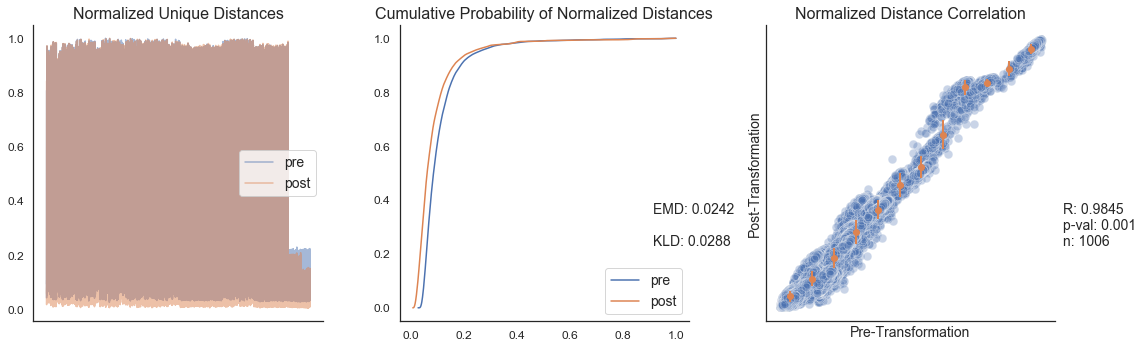

Knn Preservation: 96.5387

CPU times: user 32.4 s, sys: 4.61 s, total: 37 s
Wall time: 38.1 s


In [38]:
%%time
# look at DCA vs 500-feature dataset 
# transform==None for distance matrix here bc that's the input to DCA
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform=None), 
                                  post=P14Retina_0_DCA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k), 
                                                       post=P14Retina_0_DCA.knn_graph(k))))

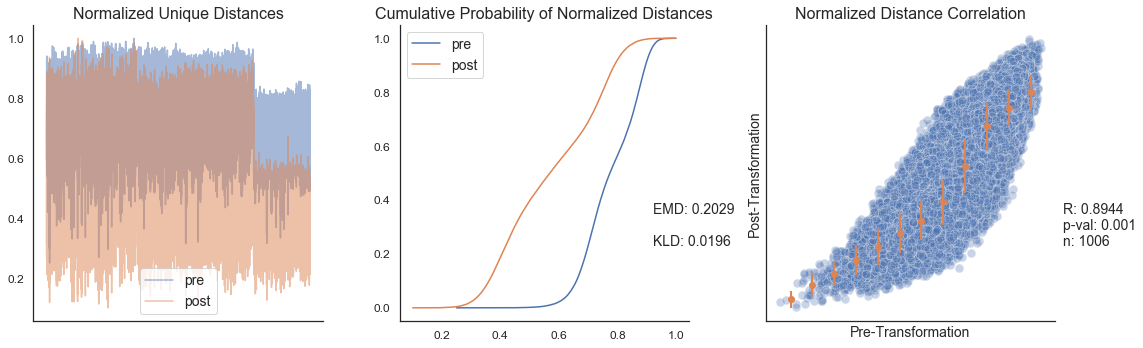

Knn Preservation: 96.9268

CPU times: user 32.1 s, sys: 5.24 s, total: 37.3 s
Wall time: 38.8 s


In [39]:
%%time
# look at 33-component PCA vs 500-feature dataset to compare to DCA
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_PCA33.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_PCA33.knn_graph(k))))

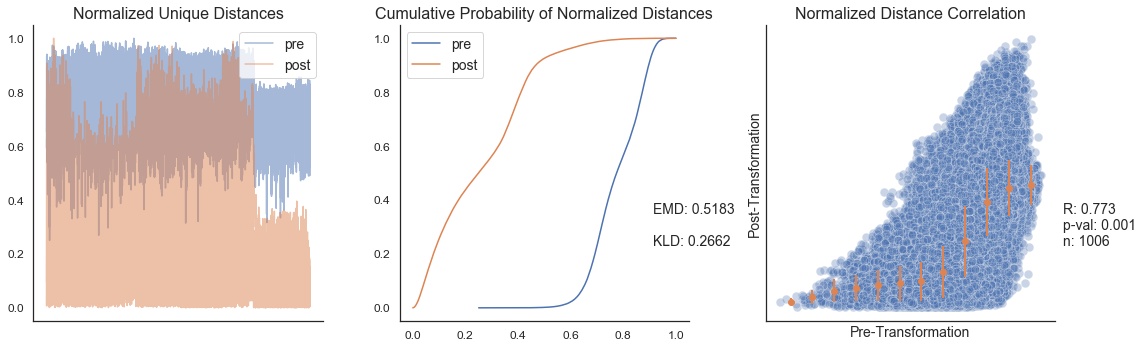

Knn Preservation: 95.4043

CPU times: user 30.2 s, sys: 3.78 s, total: 33.9 s
Wall time: 34.7 s


In [40]:
%%time
# look at ZIFA vs 500-feature dataset 
# transform==arcsinh for distance matrix here bc that's the input
mantel, EMD, KLD = compare_euclid(pre=P14Retina_0.distance_matrix(transform='arcsinh', scale=1000), 
                                  post=P14Retina_0_ZIFA.distance_matrix())
print('Knn Preservation: {}\n'.format(knn_preservation(pre=P14Retina_0.knn_graph(k, transform='arcsinh', scale=1000), 
                                                       post=P14Retina_0_ZIFA.knn_graph(k))))